# Getting started with Starmon-7

**Authors:** Marios Samiotis (m.samiotis@tudelft.nl)

**Date:** February 14, 2025

# 1. Introduction

In this notebook we will get started with using the Starmon-7 backend which exists at the Quantum Inspire 2.0 cloud services!

For optimal performance, make sure that you are running this notebook within a customized Python 3.12 environment which includes the packages "quantuminspire" and "qiskit-quantuminspire".

For detailed instructions on how to create such a Python environment, follow the instructions in the README file, [https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/README.md](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/README.md).

Useful links:
1. [Starmon-7 Fact Sheet](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/Starmon7_FactSheet.pdf)
2. [Starmon-7 Performance Dashboard](https://monitoring.qutech.support/public-dashboards/7171f0e3cfc44995a97dff9001c4d7d1?orgId=1)
3. [Starmon-7 Performance Metrics [live updated]](https://dicarlolab.tudelft.nl/Starmon7_performance.html)
4. [Starmon-7 Fridge Parameters [live updated]](https://dicarlolab.tudelft.nl/Starmon7_fridge.html)

First, we will run the following cell in order to login to the Quantum Inspire platform. You will need an account in order to login to the platform.

In [1]:
! qi login "https://api.quantum-inspire.com"

Please continue logging in by opening: https://auth.quantum-inspire.com/activate?user_code=KVFD-ZNNP in your browser
If promped to verify a code, please confirm it is as follows: KVFD-ZNNP
Login successful!
Using member ID 10


Run the following cell for all necessary library imports,

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_quantuminspire.qi_provider import QIProvider
import matplotlib.pyplot as plt
from qi_utilities.utility_functions.result_processing import return_raw_data, get_raw_data_counts, get_raw_data_prob
from scipy.optimize import curve_fit

# 2. Connect to the Quantum Inspire backend Starmon-7

We will first need to connect to the Quantum Inspire provider, by running the following cell,

In [3]:
provider = QIProvider()

You may see the full list of all available backends of Quantum Inspire platform by running

In [4]:
provider.backends()

[<qiskit_quantuminspire.qi_backend.QIBackend object at 0x166bb2690 (name=QX emulator, id=1)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x166bb26f0 (name=Starmon-7, id=3)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x167500740 (name=Tuna-5, id=4)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x166a7b770 (name=Ry emulator, id=5)>]

We now connect to the backend Starmon-7 backend by running the following cell,

In [5]:
backend_name = "Starmon-7"
backend = provider.get_backend(name=backend_name)

The Starmon-7 is a superconducting quantum processor of 7 qubits, where the qubits are connected together in a specific configuration. By running the cell below, one can print the connectivity (otherwise known as "coupling map") of the processor,

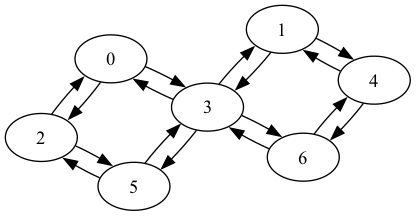

In [6]:
backend.coupling_map.draw()

We refer to any single- or multi-qubit operations that one may apply on the qubits of Starmon-7 as "instructions". One may get the full list of allowed instructions on Starmon-7 backend by running the following cell,

In [ ]:
backend.instructions

When running a quantum algorithm one needs to choose a number of shots to be performed for the given quantum circuit. The maximum number of allowed shots on Starmon-7 can be obtained by running the command

In [ ]:
backend.max_shots

# 3. Running your first quantum circuit on Starmon-7

Here we will write a quantum circuit which creates a Bell-pair state between two qubits. For more information concerning what a Bell-pair state is, visit [https://www.quantum-inspire.com/kbase/hello-quantum-world/](https://www.quantum-inspire.com/kbase/hello-quantum-world/).

To achieve this, naturally, we have to apply a two-qubit operation between two qubits that are nearest neighbors. We can write such a program in two ways: either we take into account the number of qubits and connectivity of the device while writing the code, or we run a very simple program consisting of two qubits and we let the Qiskit transpiler take care of mapping of our operations on Starmon-7.

In Section 3.1. we will create a quantum circuit with a quantum register of 7 qubits, respecting the connectivity of the device, while in Sections 3.2 and 3.3. we will use the Qiskit transpiler.

## 3.1. Creating a Bell-pair state without the use of Qiskit transpiler

Since we are not using the Qiskit transpiler, we have to be careful and define the correct number of qubits, as well as perform two-qubit operations on qubits that are connected together (see the coupling map of the processor above).

In addition, one may consult the Starmon-7 performance webpage, [https://dicarlolab.tudelft.nl/Starmon7_performance.html](https://dicarlolab.tudelft.nl/Starmon7_performance.html), in order to be informed for which qubit pair to choose: the one with the best reported two-qubit fidelity. Be careful not to use any qubit-pair that may have been marked with red color, indicating that it is insufficiently tuned up due to calibration errors.

At the time of writing this guide, the qubit-pair Q3-Q6 had the best reported performance metrics, and was therefore being chosen,

In [ ]:
qubit_0 = 0
qubit_1 = 2

qc = QuantumCircuit(7, 2)

qc.h(qubit_0)
qc.cx(qubit_0, qubit_1)
qc.measure(qubit_0, cbit=0)
qc.measure(qubit_1, cbit=1)

You may visualize the above quantum circuit by running the following cell,

In [ ]:
qc.draw('mpl')

Now we will run the above circuit on the Starmon-7 backend. We choose for the number of circuit shots the maximum allowed, which as we have already seen in Section 2. is given by "backend.max_shots".

Usually for regular-sized jobs and a normal queue, the algorithm should take a few seconds of run time, and the execution result should be retrieved within a minute. In any case, it is much safer to request a timeout of 600 seconds (or perhaps longer), which is already 10 minutes and should be good enough.

In [ ]:
nr_shots = backend.max_shots
job = backend.run(qc, shots=nr_shots)
result = job.result(timeout = 600)

We now gather the measurement counts and visualize the results,

In [ ]:
counts = result.get_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

for bit_string in counts:
    ax.bar(bit_string, counts[bit_string] / nr_shots, color='orange')

ax.set_xlabel("Bit-strings")
ax.set_ylabel("Probabilities")
ax.set_title(f"Bell-state preparation\nQubits Q{qubit_0} - Q{qubit_1}")

ax.set_ylim(0.0, 1.05)

plt.grid(axis='y')
plt.show()

## 3.2. Creating a Bell-pair state with the use of Qiskit transpiler

Here we will be using Qiskit's "transpile" function, which simplifies circuit writing since we do not need to bother with defining the number of qubits of the backend, or take into consideration the coupling map and allowed set of instructions of Starmon-7; the transpiler does that for us.

Therefore, we can define a simple circuit consisting of only two qubits for now,

In [ ]:
qubit_0 = 0
qubit_1 = 1

qc = QuantumCircuit(2, 2)

qc.h(qubit_0)
qc.cx(qubit_0, qubit_1)
qc.measure(qubit_0, cbit=0)
qc.measure(qubit_1, cbit=1)

In [ ]:
qc.draw('mpl')

In order to run the above circuit on Starmon-7, we will need to transpile it.

But how does the transpiler know which qubit pair to choose? If we do not specify it, it will begin with the first entry of the coupling map of the device, which is qubit pair Q0-Q2, and so on.

Nevertheless, we have the freedom to define a qubit priority list: by consulting the performance page [https://dicarlolab.tudelft.nl/Starmon7_performance.html](https://dicarlolab.tudelft.nl/Starmon7_performance.html), we can create a list of qubits with the best performance, followed by the least favorable qubits.

At the day of writing this guide, the best list seemed to be qubit_priority_list = [3, 6, 4, 1, 5, 0, 2]

In [ ]:
qubit_priority_list = [3, 6, 4, 1, 5, 0, 2]

In [ ]:
qc_transpiled = transpile(qc, backend, initial_layout=qubit_priority_list[0:qc.num_qubits])

In [ ]:
qc_transpiled.draw('mpl')

We can see that the transpiler added an additional 5 qubits itself, which are referenced as "ancilla" qubits, since they are not being used in the algorithm.

We will now run the transpiled circuit on Starmon-7,

In [ ]:
nr_shots = backend.max_shots
job = backend.run(qc_transpiled, shots=nr_shots)
result = job.result(timeout = 600)

and gather the results in the same way as before,

In [ ]:
counts = result.get_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

for bit_string in counts:
    ax.bar(bit_string, counts[bit_string] / nr_shots, color='orange')

ax.set_xlabel("Bit-strings")
ax.set_ylabel("Probabilities")
ax.set_title(f"Bell-state preparation\nQubits Q{qubit_priority_list[0]} - Q{qubit_priority_list[1]}")

ax.set_ylim(0.0, 1.05)

plt.grid(axis='y')
plt.show()

## 3.3. Creating a Bell-pair state with the use of Qiskit transpiler (ADVANCED)

By taking a look at the transpiled circuit of the previous example, we see that it uses a CNOT gate between two qubits. Though, looking at the Starmon-7 [fact sheet](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/Starmon7_FactSheet.pdf), we read in section VI "Qubit operations" that the only native two-qubit gate in Starmon-7 is the CZ gate. What does that mean in practice?

Whenever we send a quantum circuit to Starmon-7 which includes a CNOT, the CNOT is further decomposed by the Starmon-7 internal software into a combination of single-qubit gates and a CZ gate, a transpilation step which is not visible to the user.

If the user is concerned with optimizing their circuits so that they send jobs to Starmon-7 with circuits which do not need to be further decomposed by the Starmon-7 internal software, then they need to define the following basis gates list which corresponds to the accurate set of allowed instructions of the device, which we will then pass to the Qiskit transpiler manually,

In [ ]:
starmon7_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz']

Now let us define once again the Bell pair state preparation quantum circuit,

In [ ]:
qubit_0 = 0
qubit_1 = 1

qc = QuantumCircuit(2, 2)

qc.h(qubit_0)
qc.cx(qubit_0, qubit_1)
qc.measure(qubit_0, cbit=0)
qc.measure(qubit_1, cbit=1)

In [ ]:
qc.draw('mpl')

After defining a qubit priority list, we will manually pass the Starmon-7 basis gates to the transpiler,

In [ ]:
qubit_priority_list = [0, 2, 4, 1, 5, 3, 6]

In [ ]:
qc_transpiled = transpile(qc, backend, initial_layout=qubit_priority_list[0:qc.num_qubits], basis_gates=starmon7_basis_gates)

In [ ]:
qc_transpiled.draw('mpl')

In the above circuit, we see the further decomposition of the CNOT gate into single-qubit rotations and a CZ gate. We can be sure now that the above circuit is the actual instruction list that Starmon-7 will eventually execute.

In [ ]:
nr_shots = backend.max_shots
job = backend.run(qc_transpiled, shots=nr_shots)
result = job.result(timeout = 600)

In [ ]:
counts = result.get_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

for bit_string in counts:
    ax.bar(bit_string, counts[bit_string] / nr_shots, color='orange')

ax.set_xlabel("Bit-strings")
ax.set_ylabel("Probabilities")
ax.set_title(f"Bell-state preparation\nQubits Q{qubit_priority_list[0]} - Q{qubit_priority_list[1]}")

ax.set_ylim(0.0, 1.05)

plt.grid(axis='y')
plt.show()

# 4. Performing a qubit $T_1$ measurement using mid-circuit measurements

Here we will perform a simple measurement in order to estimate the relaxation time $T_1$ of a qubit, using the mid-circuit functionality of the Quantum Inspire SDK. For more information concerning what the qubit relaxation time is or how do we measure it, take a look at [A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560v5), Section III. B. 2.

We will first define the experiment parameters,

In [7]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
total_time = 150e-6 # total measurement time in units of [s]
nr_points = 31 # number of measurement points

and then we define the experiment circuit. The user does not need to alter the following code,

In [8]:
cycle_time = 20e-9 # cycle time of the Central Controller (CC) instrument
dt = total_time / nr_points
measurement_times = np.linspace(start = 0.0, stop = total_time, num = nr_points)

qc = QuantumCircuit(7, nr_points)
qc.x(qubit_nr) # qubit initialization to the |1> state
qc.measure(qubit = qubit_nr, cbit = 0) # initial measurement at time t=0
for time_idx in range(1, nr_points):
    qc.delay(duration = int((dt / cycle_time)), qarg = qubit_nr) # delay in units of CC cycles
    qc.measure(qubit = qubit_nr, cbit = time_idx)

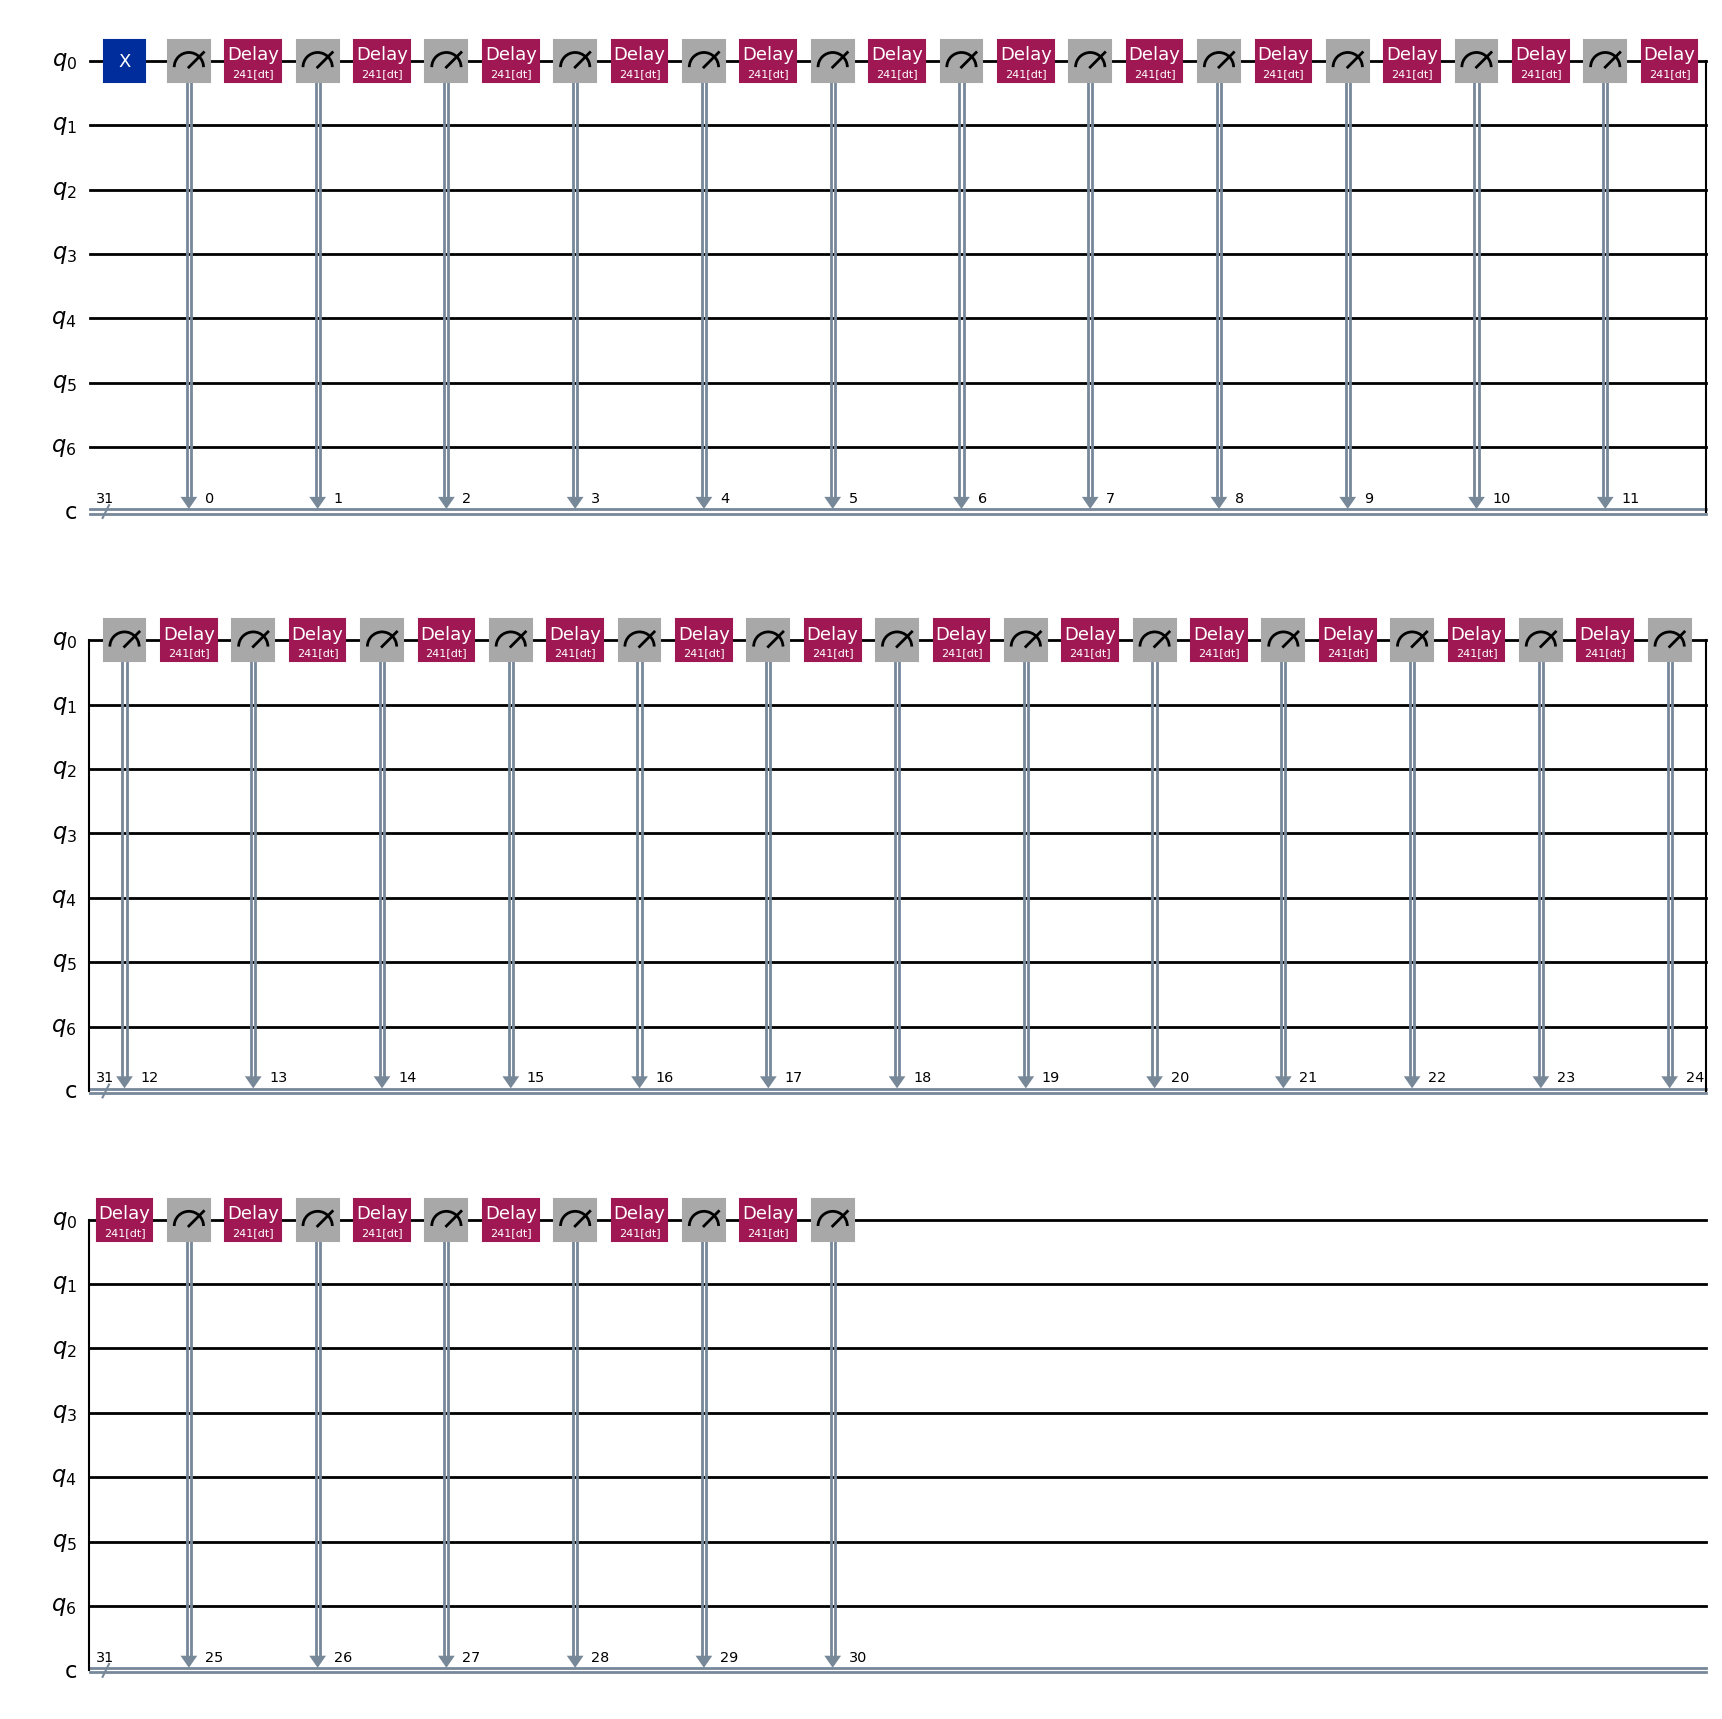

In [9]:
qc.draw('mpl')

Let us understand the above circuit. A $T_1$ measurement begins with an initial pi-pulse (X-gate) on the measured qubit, followed by an idle time which we refer to as the "total_time", where we sample the qubit state for a number of "nr_points".

The "total_time" of the experiment is chosen to be approximately 4 times the qubit relaxation time $T_1$, which was already known to us at the time of writing this guide, and thus we chose $150 \mu s$ as the total duration of the experiment.

You will see in the circuit multiple measurement blocks, equal to the "nr_points". These blocks are what we refer to as "mid-circuit measurements", since after each measurement block the circuit continues, until the final circuit measurement.

How do the results of such a measurement look like? We save the outcome of each measurement block to a separate bit in the bit register, which has a total size equal to the "nr_points".

Notice how in the method ".run()" we set "memory = True", which returns the raw data of the experiment.

In [10]:
nr_shots = backend.max_shots # NOTE: one has to be careful with nr_shots using mid-circuit measurements
                             #       if the job fails to be executed, reduce the nr_shots
job = backend.run(qc, shots=nr_shots, memory = True) # NOTE: memory is set to True in order to return raw data!
result = job.result(timeout = 600)

Let us now investigate how the data is organized by running the custom function "return_raw_data()" from utility_functions.py,

In [11]:
raw_data = return_raw_data(qc, result)

The raw_data list has a total "nr_shots" entries, since we run this circuit for that particular number of shots, and each entry has "nr_points" bits, with each containing the result of each measurement block for the particular circuit run.

The right-most bit of each bit string corresponds to the first measurement block of the quantum circuit, while the left-most bit of each bit string corresponds to the final measurement.

For example, the entry "raw_data[0][-1]" gives us the result of the first measurement block of the very first circuit shot. You will notice that statistically, in most of the entries of "raw_data", the right-most bit is equal to '1', since this is the measurement that follows right after applying the X gate on the qubit. The qubit thus has a negligible time to relax to the $|0 \rangle$ state until the first measurement block, and we mostly measure it in the state $|1\rangle$.

In [12]:
len(raw_data) # size of the raw_data list, equal to nr_shots

19192

In [13]:
len(raw_data[0]) # size of the bit string of each circuit shot, equal to nr_points

31

Similarly to obtaining the measurement counts of a quantum circuit with a single measurement, we can do the same for all measurement block by running the custom function "get_raw_data_counts()" from utility_functions.py,

In [14]:
raw_data_counts = get_raw_data_counts(qc, result)

The first entry of the "raw_data_counts", raw_data_counts[0], corresponds to the total counts of the first measurement block of the quantum circuit, while the last entry raw_data_counts[-1] corresponds to the total counts of the final measurement block.

By running the following custom function, "get_raw_data_prob()", from utility_functions.py, we convert the counts of each measurement block to probabilities.

Finally, we plot the probability of the qubit being in the state $|1\rangle$ for each measurement block, which decreases exponentially with time. By fitting an exponential curve on the measurement data, we extract the relaxation time $T_1$ of the qubit,

In [15]:
raw_data_prob = get_raw_data_prob(qc, result)

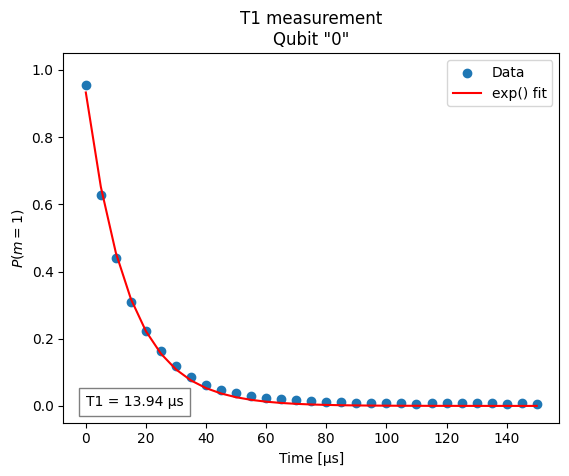

In [16]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

def exponential_func(x, a, b):
    return a * np.exp(b*x)
params, covariance = curve_fit(exponential_func, measurement_times, prob_state_1)
a_fit, b_fit = params
exponential_fit = exponential_func(measurement_times, a_fit, b_fit)

fig, ax = plt.subplots()
ax.scatter(1e6*measurement_times, prob_state_1, label='Data')
ax.plot(1e6*measurement_times, exponential_fit, label='exp() fit', color='r')
ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'$P(m=1)$')
ax.set_title(f'T1 measurement\nQubit "{qubit_nr}"')

ax.text(x = 0.0, y = 0.0, s = f'T1 = {- 1e6 * 1 / b_fit:.2f} μs',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
ax.set_ylim(-0.05, 1.05)

plt.legend()
plt.show()

# 5. Performing a Rabi oscillation using mid-circuit measurements

In order to perform a Rabi oscillation on a qubit, we need to apply a transversal gate (we choose gate X) of varied amplitude for different measurement steps. A varied amplitude in our case translates to a varied angle of the applied X rotation.

By consulting the Starmon-7 [fact sheet](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/Starmon7_FactSheet.pdf), we find in section VI "Qubit operations" that all x-axis and y-axis rotations, $R_{x}(\theta)$ and $R_{y}(\theta)$ respectively, can be applied with $\theta$ being any multiple of $\pi / 28$.

This means that the rotation angle cannot take any other value in between, and any angle that is not a multiple of $\pi / 28$ will be rounded to the nearest multiple of $\pi / 28$. With this experiment, we will demonstrate what happens when we try to go beyond this hardware limitation.

In a similar fashion to what we did in Section 4., we will first define the experiment parameters,

In [ ]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
angle_step = np.pi / 28
total_steps = 56

In [ ]:
qc = QuantumCircuit(7, total_steps)

for step_idx in range(total_steps):
    qc.delay(6000, qubit_nr) # initialization time for the qubit, equivalent to 120 μs
    qc.rx(step_idx * angle_step, qubit_nr)
    qc.measure(qubit = qubit_nr, cbit = step_idx)

In [ ]:
qc.draw('mpl')

Now let us run the above circuit. Notice how the nr_shots has been set to 5500, since we are using multiple measurement blocks and we risk having the job fail if we request too many.

In [ ]:
nr_shots = 5500 # NOTE: one has to be careful with nr_shots using mid-circuit measurements
                #       if the job fails to be executed, reduce the nr_shots
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600)

We obtain the probabilities for each measurement block, and visualize them

In [ ]:
raw_data_prob = get_raw_data_prob(qc, result)

In [ ]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

def cos_func(x, a, b, c, d):
    return a * np.cos(2*np.pi*b*x + c) + d
params, covariance = curve_fit(cos_func, np.arange(0, total_steps, 1), prob_state_1)
a_fit, b_fit, c_fit, d_fit = params
cosine_fit = cos_func(np.arange(0, total_steps, 1), a_fit, b_fit, c_fit, d_fit)

fig, ax = plt.subplots(figsize=(18, 5))
ax.scatter(np.arange(0, total_steps, 1), prob_state_1, label='Data')
ax.plot(np.arange(0, total_steps, 1), cosine_fit, label='cos() fit', color='r')
ax.set_xlabel('Applied pulse')
ax.set_ylabel(r'$P(m=1)$')
ax.set_title(f'Rabi oscillation\nQubit "{qubit_nr}"')

labels = []
for step_idx in range(total_steps):
    angle_in_degrees = (360 / (2 * np.pi)) * step_idx * angle_step
    step_label = f"rx{round(angle_in_degrees)}"
    labels.append(step_label)
label_locs = np.arange(0, total_steps, 1)
ax.set_xticks(label_locs)
ax.set_xticklabels(labels, rotation=65)
ax.set_ylim(-0.05, 1.05)

plt.grid()
plt.legend()
plt.show()

Now let us try to perform x-axis rotations with a smaller angle step from $\pi / 28$, let us request half of that,

In [ ]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
angle_step = np.pi / 28 / 2
total_steps = 56

In [ ]:
qc = QuantumCircuit(7, total_steps) # NOTE: we should put backend.num_qubits here

for step_idx in range(total_steps):
    qc.delay(6000, qubit_nr) # initialization time for the qubit, equivalent to 120 μs
    qc.rx(step_idx * angle_step, qubit_nr)
    qc.measure(qubit = qubit_nr, cbit = step_idx)

In [ ]:
nr_shots = 5500 # NOTE: one has to be careful with nr_shots using mid-circuit measurements
                #       if the job fails to be executed, reduce the nr_shots
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600)

In [ ]:
raw_data_prob = get_raw_data_prob(qc, result)

In [ ]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

def cos_func(x, a, b, c, d):
    return a * np.cos(2*np.pi*b*x + c) + d
params, covariance = curve_fit(cos_func, np.arange(0, total_steps, 1), prob_state_1)
a_fit, b_fit, c_fit, d_fit = params
cosine_fit = cos_func(np.arange(0, total_steps, 1), a_fit, b_fit, c_fit, d_fit)

fig, ax = plt.subplots(figsize=(18, 5))
ax.scatter(np.arange(0, total_steps, 1), prob_state_1, label='Data')
ax.plot(np.arange(0, total_steps, 1), cosine_fit, label='cos() fit', color='r')
ax.set_xlabel('Applied pulse')
ax.set_ylabel(r'$P(m=1)$')
ax.set_title(f'Rabi oscillation\nQubit "{qubit_nr}"')

labels = []
for step_idx in range(int(total_steps / 2)):
    angle_in_degrees = (360 / (2 * np.pi)) * step_idx * angle_step * 2
    step_label = f"rx{round(angle_in_degrees)}"
    labels.append(step_label)
label_locs = np.arange(0, total_steps, 2)
ax.set_xticks(label_locs)
ax.set_xticklabels(labels, rotation=65)
ax.set_ylim(-0.05, 1.05)

plt.grid()
plt.legend()
plt.show()

From the above plot, we can see that any rotation angle that has smaller precision than $\pi / 28$, has been rounded to the nearest multiple of $\pi / 28$, and therefore the data appears to be quantized in pairs. Reasonable, since we halved the angle step of each rotation.